In [64]:
from common import *

In [65]:
df_fingerprint_model_params = pd.read_csv("./data/filtered/apb/fingerprint_model_params.csv")
df_fingerprint_model_params

,target_mac,monitor_mac,rssi_0,n
0,20f094118214,08a6f7a1e5c8,-46.488243,2.914109
1,20f094118214,24a1602ccfab,-44.196182,2.998748
2,20f094118214,483fda467e7a,-47.123330,2.935286
3,20f094118214,a0a3b3ff35c0,-49.003914,1.870136
4,20f094118214,a0a3b3ff66b4,-57.520579,1.186322
5,20f094118214,a4cf12fdaea9,-47.399108,2.814001
6,20f094118214,d8bfc0117c7d,-55.737894,1.407107
7,20f094118214,f8b3b732fb6c,-44.573545,3.077004
8,20f094118214,f8b3b73303e8,-55.575197,2.555942
9,20f094118214,f8b3b734347c,-53.791912,1.383097


In [66]:
def prep_path_data(df):
    # Merge coordinates into single columns
    df["anchor_position"] = list(zip(df["anchor_position_x"], df["anchor_position_y"]))

    # Round the coordinates in the anchor_position and target_position columns
    df["anchor_position"] = df["anchor_position"].apply(lambda pos: (round(pos[0]), round(pos[1])))

    # Drop the original coordinate columns if no longer needed
    df.drop(columns=["anchor_position_x", "anchor_position_y", "target_position_x", "target_position_y"], inplace=True)

    df.sort_values("timestamp", inplace=True)

    return df

In [67]:
def prep_data(df):
    # Merge coordinates into single columns
    df["anchor_position"] = list(zip(df["anchor_position_x"], df["anchor_position_y"]))
    df["target_position"] = list(zip(df["target_position_x"], df["target_position_y"]))

    # Round the coordinates in the anchor_position and target_position columns
    df["anchor_position"] = df["anchor_position"].apply(lambda pos: (round(pos[0]), round(pos[1])))
    df["target_position"] = df["target_position"].apply(lambda pos: (round(pos[0]), round(pos[1])))

    # Drop the original coordinate columns if no longer needed
    df.drop(columns=["anchor_position_x", "anchor_position_y", "target_position_x", "target_position_y"], inplace=True)

    # Group by monitor_mac and target_position, and calculate the median RSSI
    df_median_rssi = (
        df.groupby(["target_position", "target_mac", "monitor_mac", "anchor_position"], as_index=False)
        .agg({"rssi": "median"})
    )

    return df_median_rssi

In [68]:
# fingerprint data
df_fingerprint_pixel9 = prep_data(pd.read_csv("./data/filtered/apb/Pixel9.csv"))
df_fingerprint_p20 = prep_data(pd.read_csv("./data/filtered/apb/P20_Pro.csv"))
df_fingerprint_iphone = prep_data(pd.read_csv("./data/filtered/apb/iPhone.csv"))

df_fingerprint_median = pd.concat([df_fingerprint_pixel9, df_fingerprint_p20, df_fingerprint_iphone]).reset_index()

In [69]:
def get_rolling_rssi_data(df_path):
    # Custom function to calculate the median of the last 50 rows
    def compute_rolling_rssi(df):
        df = df.sort_values("timestamp")  # Sort by timestamp
        df["rolling_rssi_1"] = df["rssi"].rolling(window=1, min_periods=1).median()
        df["rolling_rssi_25"] = df["rssi"].rolling(window=25, min_periods=1).median()
        df["rolling_rssi_50"] = df["rssi"].rolling(window=50, min_periods=1).median()
        df["rolling_rssi_100"] = df["rssi"].rolling(window=100, min_periods=1).median()
        return df

    # Apply rolling RSSI calculation per monitor_mac
    df_transformed = df_path.groupby(["target_mac", "monitor_mac"], group_keys=False).apply(compute_rolling_rssi)

    # Ensure 10 rows per timestamp (one per monitor_mac)
    unique_timestamps = df_path["timestamp"].unique()
    unique_target_macs = df_path["target_mac"].unique()
    unique_monitor_macs = df_path["monitor_mac"].unique()

    rows = []
    for timestamp in unique_timestamps:
        for target_mac in unique_target_macs:
            for monitor_mac in unique_monitor_macs:
                # Get the most recent data for this monitor_mac and timestamp
                recent_data = df_transformed[
                    (df_transformed["target_mac"] == target_mac) & (df_transformed["monitor_mac"] == monitor_mac) & (df_transformed["timestamp"] <= timestamp)
                ].sort_values("timestamp", ascending=False).head(1)
                
                if not recent_data.empty:
                    rows.append({
                        "timestamp": timestamp,
                        "monitor_mac": monitor_mac,
                        "target_mac": target_mac,
                        "rssi_1": recent_data.iloc[0]["rolling_rssi_1"],
                        "rssi_25": recent_data.iloc[0]["rolling_rssi_25"],
                        "rssi_50": recent_data.iloc[0]["rolling_rssi_50"],
                        "rssi_100": recent_data.iloc[0]["rolling_rssi_100"],
                        "anchor_position": recent_data.iloc[0]["anchor_position"],
                    })

    # Final transformed DataFrame
    df_final_all = pd.DataFrame(rows)
    return df_final_all


In [70]:
class AbstractLocalization(ABC):

    def __init__(self):
        pass

    @abstractmethod
    def localize(self, rssis):
        pass
    
    def get_relevant_anchor_stats(self, anchor_stats, rssis):
        monitor_macs_intersec = anchor_stats.keys() & rssis.keys()
        anchor_stats_intersec = [anchor_stats[monitor_mac] for monitor_mac in monitor_macs_intersec]
        rssis_intersec = [rssis[monitor_mac] for monitor_mac in monitor_macs_intersec]
        
        return monitor_macs_intersec, anchor_stats_intersec, rssis_intersec

class TrilaterationLeastSquaresLocalization(AbstractLocalization):
    def __init__(self, anchor_positions, monitor_model_params):
        super().__init__()
        
        self.anchor_positions = anchor_positions
        self.monitor_model_params = monitor_model_params
    
    def localize(self, rssis):
        relevant_monitor_macs, relevant_positions, relevant_rssis = self.get_relevant_anchor_stats(self.anchor_positions, rssis)
        relevant_distances = [inverse_path_loss_model(rssi, self.monitor_model_params[monitor_mac][0], self.monitor_model_params[monitor_mac][1]) * 100.0 for rssi, monitor_mac in zip(relevant_rssis, relevant_monitor_macs)] # m to cm

        relevant_positions = np.array(relevant_positions)
        relevant_distances = np.array(relevant_distances)
        print(relevant_positions)

        # relevant_positions = relevant_positions / 100.0
        # relevant_distances = relevant_distances / 100.0

        print("rssis:")
        print(relevant_rssis)
        print("positions:")
        print(relevant_positions)
        print("distances:")
        print(relevant_distances)
        
        # Number of known positions
        n = len(relevant_positions)
        
        # Build the A matrix and b vector
        A = []
        b = []
        
        x_n, y_n = relevant_positions[n-1]
        d_n = relevant_distances[n-1]
        for i in range(n - 1):
            x_i, y_i = relevant_positions[i]
            d_i = relevant_distances[i]
            A.append([2*(x_i - x_n), 2*(y_i - y_n)])
            b.append(x_i**2 + y_i**2 - x_n**2 - y_n**2 - d_i**2 + d_n**2)
        A = np.array(A)
        b = np.array(b)

        print("A:")
        print(A)
        print("b:")
        print(b)

        # Debug: Check condition number
        condition_number = np.linalg.cond(A.T @ A)
        print(f"Condition Number: {condition_number}")

        # Compute the least squares solution using the normal equation: x = (A^T A)^(-1) A^T b
        position, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

        print("Lstsq data:")
        print(position)
        print(residuals)
        print(rank)
        print(s)

        # position *= 100.0
        
        return {
            'position': position,
            'distances': {monitor_mac: distance for monitor_mac, distance in zip(relevant_monitor_macs, relevant_distances)}
        }

class TrilaterationWeightedCentroidLocalization(AbstractLocalization):
    def __init__(self, anchor_positions, monitor_model_params, weight_func):
        super().__init__()
        
        self.anchor_positions = anchor_positions
        self.monitor_model_params = monitor_model_params
        self.weight_func = weight_func
    
    def localize(self, rssis):
        relevant_monitor_macs, relevant_positions, relevant_rssis = self.get_relevant_anchor_stats(self.anchor_positions, rssis)        
        relevant_positions_np = np.array(relevant_positions)

        # Calculate the weights using the custom function
        weights = np.array([self.weight_func(rssi, self.monitor_model_params[monitor_mac][0], self.monitor_model_params[monitor_mac][1]) for rssi, monitor_mac in zip(relevant_rssis, relevant_monitor_macs)])
        weight_sum = np.sum(weights)

        # Normalize the weights so they sum up to 1
        normalized_weights = weights / weight_sum
        
        # Weighted sum of positions
        x = np.sum([w * pos[0] for w, pos in zip(normalized_weights, relevant_positions_np)])
        y = np.sum([w * pos[1] for w, pos in zip(normalized_weights, relevant_positions_np)])
        
        position = (x, y)
        
        return {
            'position': position
        }

class FingerprintingLocalization(AbstractLocalization):
    def __init__(self, df_fingerprints, background_size, heatmap_resolution=5.0): # every 5cm
        super().__init__()
        
        x = np.arange(0, background_size[0], heatmap_resolution)
        y = np.arange(0, background_size[1], heatmap_resolution)
        self.pos_lookup_x = np.append(x, background_size[0]) # include boundary
        self.pos_lookup_y = np.append(y, background_size[1])
        num_x = len(self.pos_lookup_x)
        num_y = len(self.pos_lookup_y)
            
        gx, gy = np.meshgrid(self.pos_lookup_x, self.pos_lookup_y)
        gx, gy = gx.flatten(), gy.flatten()
        
        def generate_interpolated_fingerprint_map(monitor_mac):
            monitor_rows = df_fingerprints[df_fingerprints['monitor_mac'] == monitor_mac]
            
            target_positions = monitor_rows['target_position'].to_list()
            (target_positions_x, target_positions_y) = zip(*target_positions)
            rssi_medians = monitor_rows['rssi'].to_list()
            
            
            # from https://github.com/jantman/python-wifi-survey-heatmap/blob/master/wifi_survey_heatmap/heatmap.py
            
            rbf = Rbf(target_positions_x, target_positions_y, rssi_medians, function='linear')
            z = rbf(gx, gy)
            z = z.reshape((num_y, num_x))
            
            return z
        
        monitor_macs = df_fingerprints['monitor_mac'].unique()
        self.interpolated_fingerprints = {monitor_mac: generate_interpolated_fingerprint_map(monitor_mac) for monitor_mac in monitor_macs}
    
    def localize(self, rssis):
        _, relevant_interpolated_fingerprints, relevant_rssis = self.get_relevant_anchor_stats(self.interpolated_fingerprints, rssis)
        
        diff = np.moveaxis(relevant_interpolated_fingerprints, 0, -1) - relevant_rssis        
        norm = np.linalg.norm(diff, axis=2)
        min_pos_heatmap = np.unravel_index(np.argmin(norm, axis=None), norm.shape)        
        min_pos = (self.pos_lookup_x[min_pos_heatmap[1]], self.pos_lookup_y[min_pos_heatmap[0]])
        
        position = min_pos
        
        return {
            'position': position,
            'heatmap': norm
        }

In [71]:
def path_positioning(df, df_original, rssi_column):
    anchor_positions = df_original.set_index('monitor_mac')['anchor_position'].to_dict()
    anchor_model_params = df_fingerprint_model_params.set_index('monitor_mac')[['rssi_0', 'n']].apply(tuple, axis=1).to_dict()

    def weight_rssi_9(rssi, rssi_0, n):
        return pow(abs(rssi), -9.0) # try different exponents → 9 worked best

    target_macs = []
    timestamps = []
    estimations_twcl_rssi_9 = []
    estimations_fpl = []

    for target_mac in df['target_mac'].unique():
        df_target = df[df['target_mac'] == target_mac]

        twcl_rssi_9 = TrilaterationWeightedCentroidLocalization(anchor_positions, anchor_model_params, weight_rssi_9)
        df_fingerprints_target_mac = df_fingerprint_median[df_fingerprint_median["target_mac"] == target_mac]
        print(df_fingerprints_target_mac)

        fpl = FingerprintingLocalization(df_fingerprints_target_mac, (2152, 1485)) # TODO: replace with real size

        for timestamp in df_target['timestamp'].unique():
            group = df_target[df_target['timestamp'] == timestamp]
            anchor_rssis = group.set_index('monitor_mac')[rssi_column].to_dict()

            estimation_twcl_rssi_9 = tuple(twcl_rssi_9.localize(anchor_rssis)['position'])
            estimation_fpl = tuple(fpl.localize(anchor_rssis)['position'])

            timestamps.append(timestamp)
            target_macs.append(target_mac)
            estimations_twcl_rssi_9.append(estimation_twcl_rssi_9)
            estimations_fpl.append(estimation_fpl)
    
    return pd.DataFrame({
        'timestamp': timestamps,
        'target_mac': target_macs,
        'estimation_twcl_rssi_9': estimations_twcl_rssi_9,
        'estimation_fpl': estimations_fpl
    })

In [72]:
import os.path

devices = ["Pixel9", "P20_Pro", "iPhone"]
usages = ["youtube", "standby_ping", "spotify", "standby"]
hardwares = ["esp8266", "esp32", "all"]
aggregations = ["rssi_1", "rssi_25", "rssi_50", "rssi_100"]

for device in devices:
    for usage in usages:
        required_files = [f"./data/filtered/apb/paths/{device}_path_{usage}_{hardware_label}_{aggregation}_results.csv" for hardware_label in hardwares for aggregation in aggregations]
        if all([os.path.exists(file) for file in required_files]):
            print(f"Skipping {device}: {usage}")
            continue
        else:
            print(f"Processing {device}: {usage}")

        df_path = prep_path_data(pd.read_csv(f"./data/filtered/apb/{device}_path_{usage}.csv"))

        df_final_all = get_rolling_rssi_data(df_path)
        df_final_esp8266 = filter_esp8266(df_final_all)
        df_final_esp32 = filter_esp32(df_final_all)

        dfs_hardware = [df_final_esp8266, df_final_esp32, df_final_all]

        for df_hardware, hardware_label in zip(dfs_hardware, hardwares):
            for aggregation in aggregations:
                df_path_estimations = path_positioning(df_hardware, df_path, aggregation)
                df_path_estimations = df_path_estimations.applymap(lambda x: tuple(float(item) for item in x) if isinstance(x, tuple) else x)
                filepath = f"./data/filtered/apb/paths/{device}_path_{usage}_{hardware_label}_{aggregation}_results.csv"
                os.makedirs(os.path.dirname(filepath), exist_ok=True)
                df_path_estimations.to_csv(filepath, index=False)


Skipping Pixel9: youtube
Skipping Pixel9: standby_ping
Skipping Pixel9: spotify
Skipping Pixel9: standby
Skipping P20_Pro: youtube
Skipping P20_Pro: standby_ping
Skipping P20_Pro: spotify
Skipping P20_Pro: standby
Skipping iPhone: youtube
Skipping iPhone: standby_ping
Skipping iPhone: spotify
Skipping iPhone: standby


In [73]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import get_cmap
from matplotlib.colors import LinearSegmentedColormap

def plot_paths(position_lists, algorithm_labels, alphas, background_image_path):
    """
    Plots the target position and estimated positions from multiple algorithms for multiple target devices
    across three hardware configurations.
    
    Parameters:
        df1, df2, df3 (pandas.DataFrame): DataFrames containing localization data for different hardware configurations.
        background_image_filepath (str): Filepath to the background image for plotting.
    """
    # Load the background image
    if background_image_path:
        img = plt.imread(background_image_path)
        plt.imshow(img, aspect='auto', alpha=0.5)
    
    # Define unique color gradients for each path
    color_gradients = [
        LinearSegmentedColormap.from_list("gradient1", ["blue", "cyan"]),
        LinearSegmentedColormap.from_list("gradient2", ["green", "lime"]),
        LinearSegmentedColormap.from_list("gradient3", ["red", "orange"]),
    ]

    for idx, position_list in enumerate(position_lists):
        x_values, y_values = zip(*position_list)

        n_points = len(position_list)

        # Normalize indices to range [0, 1]
        norm_indices = np.linspace(0, 1, n_points)

        # Get the corresponding colormap for this path
        cmap = color_gradients[idx % len(color_gradients)]

        # Plot the points
        # plt.plot(x_values, y_values, linestyle='-', alpha=alphas[idx], label=algorithm_labels[idx])

        # Plot each segment with a gradient
        for i in range(n_points - 1):
            plt.plot(
                x_values[i:i+2],
                y_values[i:i+2],
                color=cmap(norm_indices[i]),
                linewidth=2,
                alpha=alphas[idx],
            )

        # Mark the start and end points
        plt.scatter(x_values[0], y_values[0], color=cmap(0), edgecolor='black', label=f"{algorithm_labels[idx]} Start")
        plt.scatter(x_values[-1], y_values[-1], color=cmap(0.99), edgecolor='black', label=f"{algorithm_labels[idx]} End")
            
    # Set axis labels and title
    plt.title(f'Path', fontsize=14)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend(loc='upper right', fontsize=8)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

In [74]:
# Function to reduce each set of tuples
def reduce_coordinates(df, N, columns):
    dict_new = {}

    for column in columns:
        # Split the tuple columns into x and y
        tmp_x, tmp_y = zip(*df[column])
        
        # Create new DataFrame columns with the x and y values for both sets
        df['tmp_x'] = tmp_x
        df['tmp_y'] = tmp_y
        
        # Group by N rows and compute the mean for each set of coordinates
        reduced_df = df.groupby(df.index // N).agg({
            'tmp_x': 'mean', 'tmp_y': 'mean',
        }).reset_index(drop=True)
        
        # Combine the x and y values back into tuples
        dict_new[column] = list(zip(reduced_df['tmp_x'], reduced_df['tmp_y']))
        
        # Drop the intermediate x and y columns
        reduced_df = reduced_df.drop(columns=['tmp_x', 'tmp_y'])
    
    return pd.DataFrame(dict_new)

def new_exponential_smoothing(df, alpha, columns):
    def exponential_smoothing(series, alpha):
        x, y = zip(*series)
        smoothed_x = [x[5]]
        smoothed_y = [y[5]]

        for x in x[1:]:
            smooth_x = alpha * x + (1.0 - alpha) * smoothed_x[-1]
            smoothed_x.append(smooth_x)

        for y in y[1:]:
            smooth_y = alpha * y + (1.0 - alpha) * smoothed_y[-1]
            smoothed_y.append(smooth_y)
        
        return list(zip(smoothed_x, smoothed_y))

    for column in columns:
        df[f"{column}"] = (df.groupby("target_mac", group_keys=False)[column].apply(
            lambda group: pd.Series(exponential_smoothing(group, alpha))
        ).reset_index(drop=True))
    
    return df
        

In [75]:
import ast

real_path = [
    (1240, 570),
    (1450, 270),
    (900, 780),
    (130, 850),
    (2080, 850),
    (1070, 700),
    (1070, 570),
    (1240, 570)
]

for device in devices:
    for usage in usages:
        for hardware_label in hardwares:
            for aggregation in aggregations:
                df = pd.read_csv(f"./data/filtered/apb/paths/{device}_path_{usage}_{hardware_label}_{aggregation}_results.csv")
                df['estimation_twcl_rssi_9'] = df['estimation_twcl_rssi_9'].apply(ast.literal_eval)
                df['estimation_fpl'] = df['estimation_fpl'].apply(ast.literal_eval)
                # df_reduced = reduce_coordinates(df, 1, ["estimation_twcl_rssi_9", "estimation_fpl"])
                df_reduced = new_exponential_smoothing(df, 0.05, ["estimation_twcl_rssi_9", "estimation_fpl"])
                print(f"{device} {usage} {hardware_label} {aggregation}:")
                plot_paths([real_path, df_reduced['estimation_twcl_rssi_9'].to_list(), df_reduced['estimation_fpl'].to_list()], ['Real Path', 'TWCL (RSSI)', 'FP'], [1.0, 0.6, 0.6], './images/apb_3081_scaled_fingerprints.png')

KeyError: 'target_mac'

### 3 Devices

In [61]:
required_files = [f"./data/filtered/apb/paths/3_smartphones_{hardware_label}_{aggregation}_results.csv" for hardware_label in hardwares for aggregation in aggregations]
if all([os.path.exists(file) for file in required_files]):
    print(f"Skipping 3 devices")
else:
    print(f"Processing 3 devices")

    df_path_3_devices = prep_path_data(pd.read_csv(f"./data/filtered/apb/3_smartphones.csv"))
    df_final_3_devices_all = get_rolling_rssi_data(df_path_3_devices)
    df_final_3_devices_esp8266 = filter_esp8266(df_final_3_devices_all)
    df_final_3_devices_esp32 = filter_esp32(df_final_3_devices_all)
    dfs_3_devices_hardware = [df_final_3_devices_esp8266, df_final_3_devices_esp32, df_final_3_devices_all]
    for df_hardware, hardware_label in zip(dfs_3_devices_hardware, hardwares):
        for aggregation in aggregations:
            df_path_estimations = path_positioning(df_hardware, df_path, aggregation)
            filepath = f"./data/filtered/apb/paths/3_smartphones_{hardware_label}_{aggregation}_results.csv"
            os.makedirs(os.path.dirname(filepath), exist_ok=True)
            df_path_estimations.to_csv(filepath, index=False)

Skipping 3 devices


In [52]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import get_cmap

def plot_simultaneous_paths(df_positions, background_image_path):
    """
    Plots the target position and estimated positions from multiple algorithms for multiple target devices
    across three hardware configurations.
    
    Parameters:
        df1, df2, df3 (pandas.DataFrame): DataFrames containing localization data for different hardware configurations.
        background_image_filepath (str): Filepath to the background image for plotting.
    """
    # Load the background image
    if background_image_path:
        img = plt.imread(background_image_path)
        # ax.imshow(img, aspect='auto', alpha=0.5)

    plt.imshow(img, aspect='auto', alpha=0.5)

    for target_mac in df_positions['target_mac'].unique():
        df_target_positions = df_positions[df_positions['target_mac'] == target_mac]
        position_list = df_target_positions['estimation_twcl_rssi_9'].to_list()
        x_values, y_values = zip(*position_list)

        # Plot the points
        plt.plot(x_values, y_values, linestyle='-', label=target_mac)
            
    # Set axis labels and title
    plt.title(f'Path', fontsize=14)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend(loc='upper right', fontsize=8)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

esp8266 rssi_1:


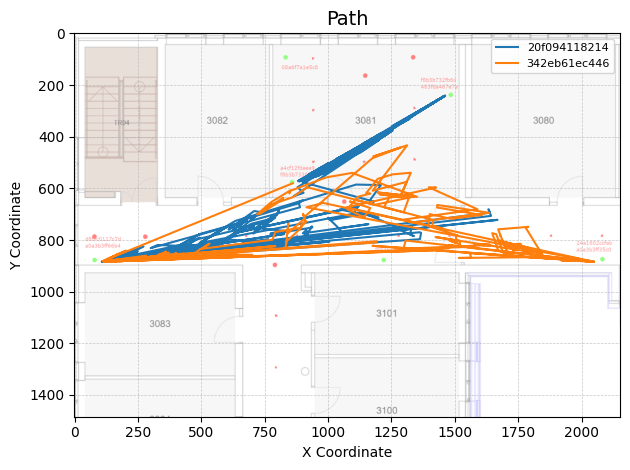

esp8266 rssi_25:


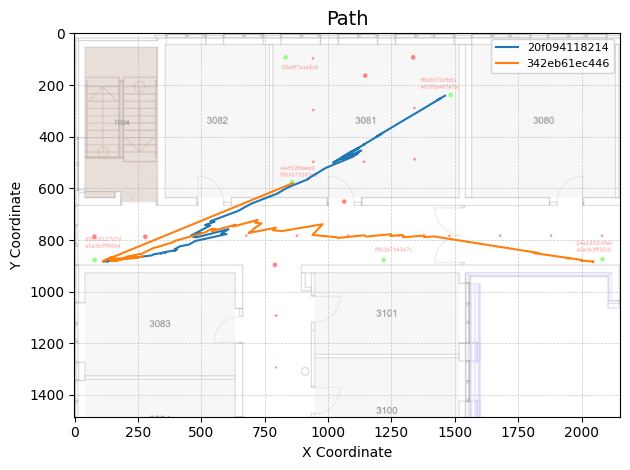

esp8266 rssi_50:


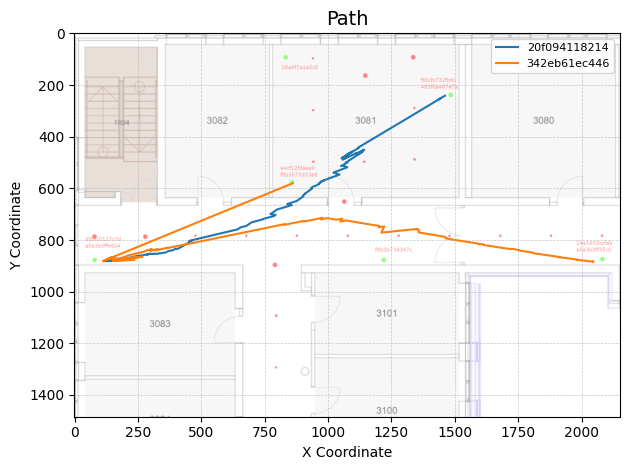

esp8266 rssi_100:


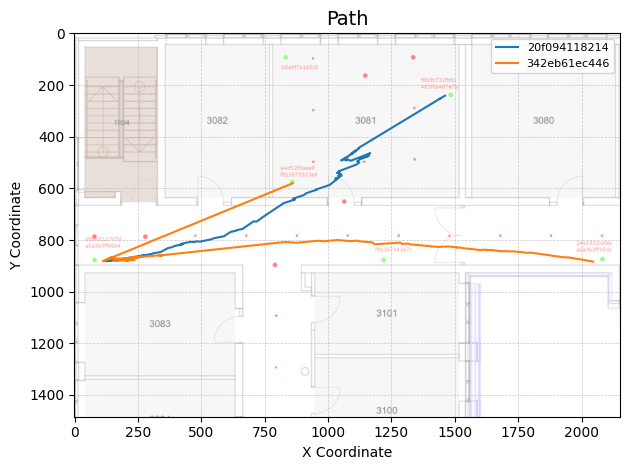

esp32 rssi_1:


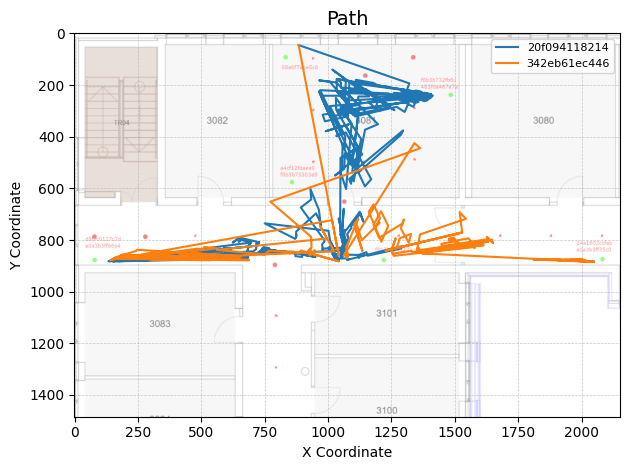

esp32 rssi_25:


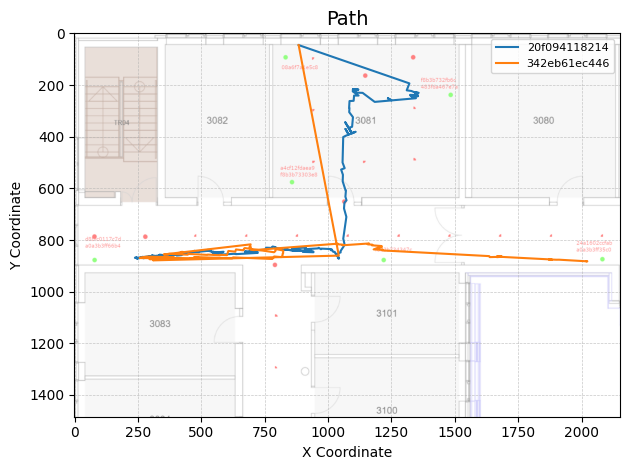

esp32 rssi_50:


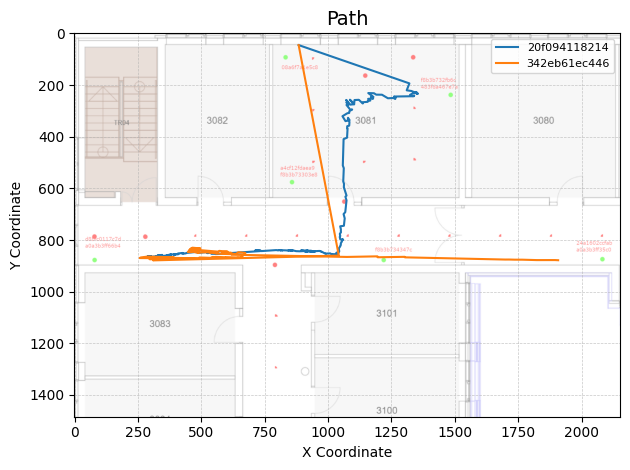

esp32 rssi_100:


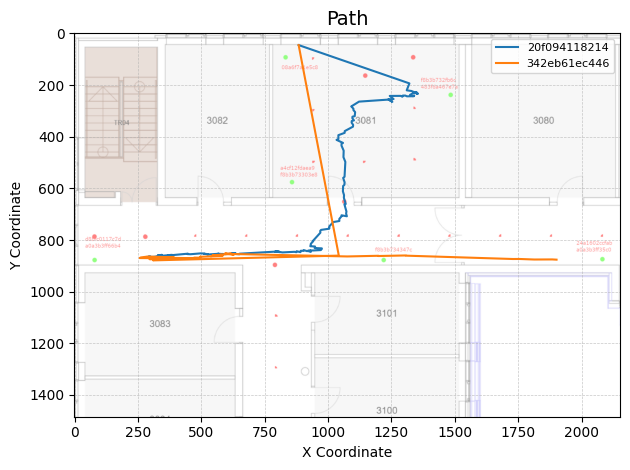

all rssi_1:


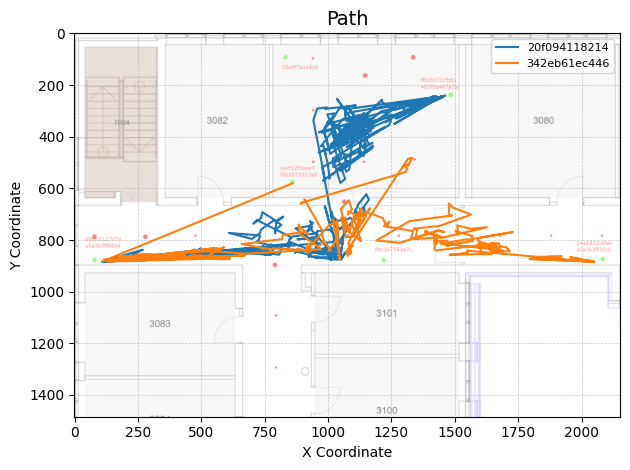

all rssi_25:


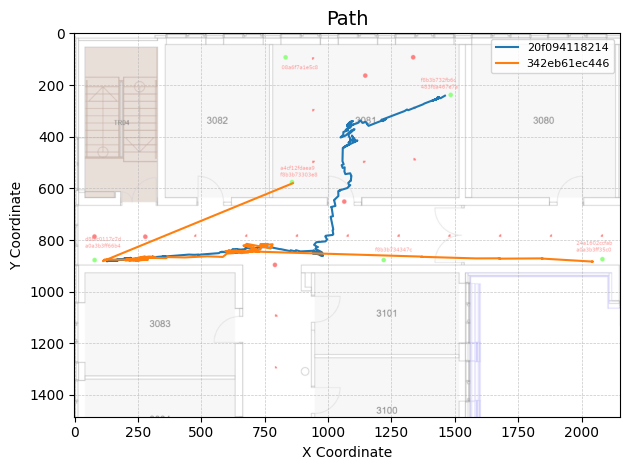

all rssi_50:


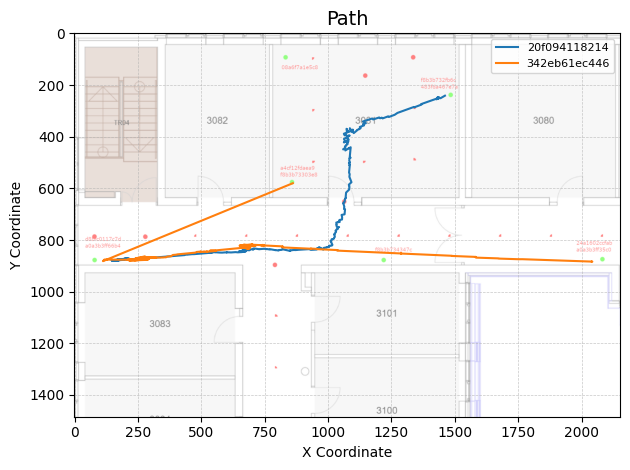

all rssi_100:


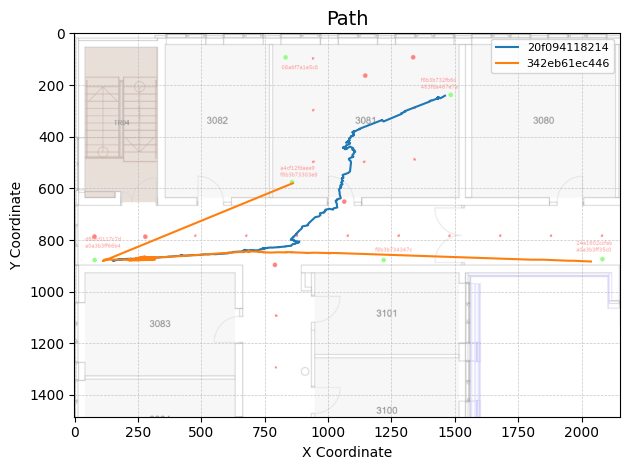

In [56]:
import ast

for hardware_label in hardwares:
    for aggregation in aggregations:
        df = pd.read_csv(f"./data/filtered/apb/paths/3_smartphones_{hardware_label}_{aggregation}_results.csv")
        df['estimation_twcl_rssi_9'] = df['estimation_twcl_rssi_9'].apply(ast.literal_eval)
        df['estimation_fpl'] = df['estimation_fpl'].apply(ast.literal_eval)
        print(f"{hardware_label} {aggregation}:")
        plot_simultaneous_paths(df, './images/apb_3081_scaled_fingerprints.png')

- "Knick" wegen erstem localization Ergebnis:
- WCL kann auch mit nur einem Datenpunkt arbeiten
- estimated location = anchor location des Datenpunktes